<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Dual_Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR", "Dual Memory ICMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
# Parameters
data_path = "data/Murdock1962.csv"
trial_query = "subject > -1"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_1_0_0", "ICMR_1_0_1", "ICMR_1_1_0", "ICMR_1_1_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]
section_tag = "Murdock1962"


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function murdock_objective_function.<locals>.objective_function at 0x2b92f5fb59d0>


14060.115502064733
23348.218353032524


<function murdock_objective_function.<locals>.objective_function at 0x2b92f7bfeb80>


14060.115502064733
23348.218353032524
<function murdock_objective_function.<locals>.objective_function at 0x2b92f8643940>


14060.115502064733
23348.218353032524
<function murdock_objective_function.<locals>.objective_function at 0x2b92f8e94550>


14060.115502064733
23348.218353032524
<function murdock_objective_function.<locals>.objective_function at 0x2b92f7e328b0>


14060.115502064733
23348.218353032524
dependencies and parameters validated


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag Murdock1962 already exist
ICMR_1_0_0, Subject 1


4467.616678797632
ICMR_1_0_0, Subject 2


5676.579935200474
ICMR_1_0_0, Subject 3


5255.759985177593
ICMR_1_0_0, Subject 4


5268.697671636578
ICMR_1_0_0, Subject 5


5546.989462773142
ICMR_1_0_0, Subject 6


5780.923134170459
ICMR_1_0_0, Subject 7


4914.138157512881
ICMR_1_0_0, Subject 8


4466.786744923269
ICMR_1_0_0, Subject 9


4790.778579902914
ICMR_1_0_0, Subject 10


5490.269810427334
ICMR_1_0_0, Subject 11


4670.882918876999
ICMR_1_0_0, Subject 12


5296.018046502516
ICMR_1_0_0, Subject 13


5944.513268889938
ICMR_1_0_0, Subject 14


6380.714160197222
ICMR_1_0_0, Subject 15


5346.487094431626


ICMR_1_0_1, Subject 1


4467.616650753772
ICMR_1_0_1, Subject 2


5676.578438198392
ICMR_1_0_1, Subject 3


5269.841576823321
ICMR_1_0_1, Subject 4


5268.003871486696
ICMR_1_0_1, Subject 5


5546.988556869586
ICMR_1_0_1, Subject 6


5781.501856920381
ICMR_1_0_1, Subject 7


4900.212448682263
ICMR_1_0_1, Subject 8


4476.529009682614
ICMR_1_0_1, Subject 9


4814.94182186919
ICMR_1_0_1, Subject 10


5490.4158959046645
ICMR_1_0_1, Subject 11


4686.50576750248
ICMR_1_0_1, Subject 12


5286.644431758493
ICMR_1_0_1, Subject 13


5944.513873010299
ICMR_1_0_1, Subject 14


6378.485902941039
ICMR_1_0_1, Subject 15


5379.017733262728
ICMR_1_1_0, Subject 1


4475.6244827060955
ICMR_1_1_0, Subject 2


5685.189632631598
ICMR_1_1_0, Subject 3


5284.505398328885
ICMR_1_1_0, Subject 4


5271.46803600605
ICMR_1_1_0, Subject 5


5558.043586917212
ICMR_1_1_0, Subject 6


5798.961258155088
ICMR_1_1_0, Subject 7


4926.200097928954
ICMR_1_1_0, Subject 8


4448.080879611223
ICMR_1_1_0, Subject 9


4821.534168384768
ICMR_1_1_0, Subject 10


5495.888649382611
ICMR_1_1_0, Subject 11


4688.702756768477
ICMR_1_1_0, Subject 12


5309.952677502985
ICMR_1_1_0, Subject 13


5950.89961677393
ICMR_1_1_0, Subject 14


6358.462224463504
ICMR_1_1_0, Subject 15


5395.6109707135965
ICMR_1_1_1, Subject 1


4475.392494820377
ICMR_1_1_1, Subject 2


5681.907686029064
ICMR_1_1_1, Subject 3


5285.452358742603
ICMR_1_1_1, Subject 4


5274.306332882076
ICMR_1_1_1, Subject 5


5556.165925155489
ICMR_1_1_1, Subject 6


5799.034011870079
ICMR_1_1_1, Subject 7


4924.158766309136
ICMR_1_1_1, Subject 8


4490.95872231083
ICMR_1_1_1, Subject 9


4821.553751701588
ICMR_1_1_1, Subject 10


5495.942760965529
ICMR_1_1_1, Subject 11


4688.747824518012
ICMR_1_1_1, Subject 12


5302.7097399260365
ICMR_1_1_1, Subject 13


5963.8224744816835
ICMR_1_1_1, Subject 14


6365.595044994146
ICMR_1_1_1, Subject 15


5418.43111926046


Text(-1.9305555555555483, 0.5, 'Individual Log-Likelihood')

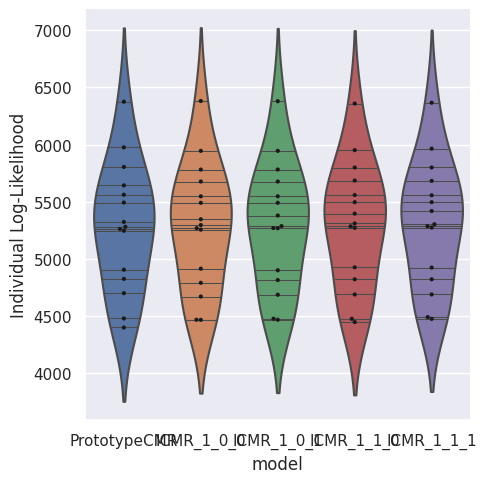

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learn_first
0,1,240,4478.987871,PrototypeCMR,0.704073,3.808707e-02,0.703502,0.075414,1.000000,0.154876,9.495896,40.375888,0.018978,0.350940,2.293764,1.079266e-09,NaN,NaN,NaN
1,2,240,5642.641431,PrototypeCMR,0.518742,6.212028e-02,0.791788,0.395615,1.000000,0.129980,3.668839,27.996900,0.015997,0.308534,7.328894,8.943584e-01,NaN,NaN,NaN
2,3,240,5280.304968,PrototypeCMR,0.644000,2.515962e-02,0.728248,0.150093,1.000000,0.111537,7.865625,37.332012,0.019671,0.296241,3.365154,8.835580e-01,NaN,NaN,NaN
3,4,240,5262.166920,PrototypeCMR,0.565376,6.799899e-02,0.852175,0.431316,1.000000,0.123191,4.765683,12.067230,0.030201,0.245761,6.437532,8.493601e-01,NaN,NaN,NaN
4,5,240,5560.925231,PrototypeCMR,0.665803,1.978730e-02,0.711746,0.118075,1.000000,0.145475,8.187909,54.078642,0.018014,0.284662,2.893090,9.329254e-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,11,240,4688.747825,ICMR_1_1_1,0.685274,2.220446e-16,0.839816,0.005655,1.000000,0.176799,44.227900,42.388347,0.029491,0.258155,1.000000,9.981736e-01,1.0,1.743573,True
71,12,240,5302.709740,ICMR_1_1_1,0.627926,2.220446e-16,0.829342,0.006439,0.678237,0.134886,20.151292,1.967647,0.020830,0.284741,1.000000,1.000000e+00,1.0,1.939851,True
72,13,240,5963.822474,ICMR_1_1_1,0.743476,1.347879e-05,0.835198,0.010862,1.000000,0.300065,26.417296,48.912082,0.017183,0.262940,1.000000,9.988060e-01,1.0,2.087151,True
73,14,240,6365.595045,ICMR_1_1_1,0.679369,2.613416e-02,0.767916,0.007507,1.000000,0.154987,28.103789,2.446232,0.014163,0.299899,1.000000,9.286539e-01,1.0,1.627350,True


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-Murdock1962fits layout-nrow=2 layout-valign="center"}

![](results/individual_Murdock1962.pdf)

|       |   ICMR_1_0_0 |   ICMR_1_0_1 |   ICMR_1_1_0 |   ICMR_1_1_1 |   PrototypeCMR |
|:------|-------------:|-------------:|-------------:|-------------:|---------------:|
| count |       15     |       15     |       15     |       15     |         15     |
| mean  |     5286.48  |     5291.19  |     5297.94  |     5302.95  |       5284.63  |
| std   |      550.786 |      547.663 |      547.999 |      545.642 |        555.078 |
| min   |     4466.79  |     4467.62  |     4448.08  |     4475.39  |       4399.96  |
| 25%   |     4852.46  |     4857.58  |     4873.87  |     4872.86  |       4865.13  |
| 50%   |     5296.02  |     5286.64  |     5309.95  |     5302.71  |       5280.3   |
| 75%   |     5611.78  |     5611.78  |     5621.62  |     5619.04  |       5601.78  |
| max   |     6380.71  |     6378.49  |     6358.46  |     6365.6   |       6374.23  |

Distribution of log-lik

In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_1_0_0')
Ttest_relResult(statistic=-0.23229651276546875, pvalue=0.8196691380084395)
Ttest_relResult(statistic=-0.23229651276546875, pvalue=0.4098345690042198)
Ttest_relResult(statistic=-0.23229651276546875, pvalue=0.5901654309957802)

('PrototypeCMR', 'ICMR_1_0_1')
Ttest_relResult(statistic=-0.8200687559599674, pvalue=0.4259193167436258)
Ttest_relResult(statistic=-0.8200687559599674, pvalue=0.2129596583718129)
Ttest_relResult(statistic=-0.8200687559599674, pvalue=0.787040341628187)

('PrototypeCMR', 'ICMR_1_1_0')
Ttest_relResult(statistic=-1.7291869825529844, pvalue=0.10575248081938154)
Ttest_relResult(statistic=-1.7291869825529844, pvalue=0.05287624040969077)
Ttest_relResult(statistic=-1.7291869825529844, pvalue=0.9471237595903093)

('PrototypeCMR', 'ICMR_1_1_1')
Ttest_relResult(statistic=-1.9726615874945002, pvalue=0.06861674996123474)
Ttest_relResult(statistic=-1.9726615874945002, pvalue=0.03430837498061737)
Ttest_relResult(statistic=-1.9726615874945002, pvalue


Ttest_relResult(statistic=-1.4772575474248, pvalue=0.9191266762497974)

('ICMR_1_0_0', 'ICMR_1_1_0')
Ttest_relResult(statistic=-2.5097781078093746, pvalue=0.024989914606390252)
Ttest_relResult(statistic=-2.5097781078093746, pvalue=0.012494957303195126)
Ttest_relResult(statistic=-2.5097781078093746, pvalue=0.9875050426968048)

('ICMR_1_0_0', 'ICMR_1_1_1')
Ttest_relResult(statistic=-3.3250106632012693, pvalue=0.005006820961210083)
Ttest_relResult(statistic=-3.3250106632012693, pvalue=0.0025034104806050416)
Ttest_relResult(statistic=-3.3250106632012693, pvalue=0.997496589519395)

('ICMR_1_0_1', 'ICMR_1_1_0')
Ttest_relResult(statistic=-1.8081156282442452, pvalue=0.09211387939887755)
Ttest_relResult(statistic=-1.8081156282442452, pvalue=0.046056939699438776)
Ttest_relResult(statistic=-1.8081156282442452, pvalue=0.9539430603005612)

('ICMR_1_0_1', 'ICMR_1_1_1')
Ttest_relResult(statistic=-3.9079165342228848, pvalue=0.0015769938760369212)
Ttest_relResult(statistic=-3.9079165342228848, pvalue=

In [9]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_1_0_0')
0.4666666666666667 0.5333333333333333
7 8

('PrototypeCMR', 'ICMR_1_0_1')
0.4 0.6
6 9

('PrototypeCMR', 'ICMR_1_1_0')
0.5333333333333333 0.4666666666666667
8 7

('PrototypeCMR', 'ICMR_1_1_1')
0.5333333333333333 0.4666666666666667
8

 7

('ICMR_1_0_0', 'ICMR_1_0_1')
0.5333333333333333 0.4666666666666667
8 7

('ICMR_1_0_0', 'ICMR_1_1_0')
0.8666666666666667 0.13333333333333333
13 2

('ICMR_1_0_0', 'ICMR_1_1_1')
0.9333333333333333 0.06666666666666667
14 1

('ICMR_1_0_1', 'ICMR_1_1_0')
0.8666666666666667 0.13333333333333333
13 2

('ICMR_1_0_1', 'ICMR_1_1_1')
0.9333333333333333 0.06666666666666667
14 1

('ICMR_1_1_0', 'ICMR_1_1_1')
0.6666666666666666 0.3333333333333333
10 5



In [10]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[1.00000000e+000 9.91096586e-013 2.07302388e-043 2.04654260e-087
 5.19077084e-120]


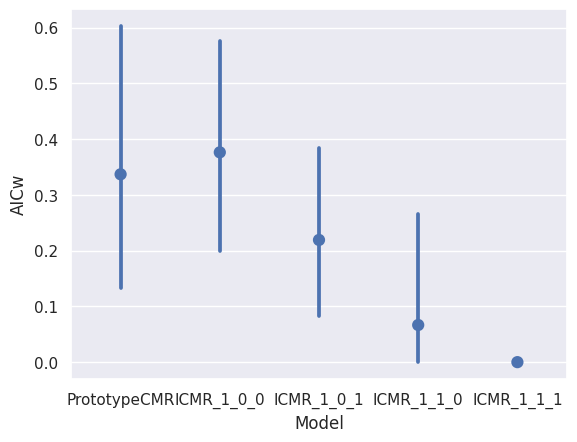

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                #model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df_from_events(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")

NameError: name 'simulate_df_from_events' is not defined